# WNS CTR PREDICTION

![Casecompetition](https://user-images.githubusercontent.com/54467567/87392648-8403b300-c572-11ea-8369-f0fb341cfe7d.PNG)

### File Reading & Merging

In [277]:
# Libraries

import os 
import zipfile
import pandas as pd
import numpy as np
import pickle
import warnings
import functools
from scipy import stats
from IPython.display import Image
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [8]:
# Data ingestion

def file_ingest():
    os.chdir(r'D:\New_files\Github\WNS-CTR-Prediction-using-H2O-AutoML-master\Train_file')
    Train_Imp = pd.read_csv('train.csv')
    Train_Item = pd.read_csv('item_data.csv')
    Train_Log = pd.read_csv('view_log.csv')
    os.chdir(r'D:\New_files\Github\WNS-CTR-Prediction-using-H2O-AutoML-master\Test_file')
    Test_Imp = pd.read_csv('test.csv')
    
    output = {'Train_Impression': Train_Imp,
              'Train_Item' : Train_Item,
              'Train_Log' : Train_Log,
              'Test_Impression': Test_Imp}
    return output

In [10]:
# Memory optimization

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [12]:
# Reading the files & optimizing the file

output = file_ingest()
train_imp = reduce_mem_usage(output['Train_Impression'])
train_item = reduce_mem_usage(output['Train_Item'])
train_log = reduce_mem_usage(output['Train_Log'])
test_item = reduce_mem_usage(output['Test_Impression'])

Memory usage of dataframe is 12.69 MB
Memory usage after optimization is: 17.19 MB
Decreased by -35.5%
Memory usage of dataframe is 6.08 MB
Memory usage after optimization is: 1.77 MB
Decreased by 70.8%
Memory usage of dataframe is 118.97 MB
Memory usage after optimization is: 53.69 MB
Decreased by 54.9%
Memory usage of dataframe is 4.15 MB
Memory usage after optimization is: 4.79 MB
Decreased by -15.4%


In [21]:
# Visualizing the training data

print('THIRD PARTY WEB ADVERTISMENT IMPRESSION','\n',train_imp.head(),'\n''\n''\n'
      '\n','USER ITEM PURCHASE INTENSION FROM ZBAY WEBSITE','\n','\n',train_item.head(),'\n''\n''\n'
      '\n','USER WEBSITE ACTIVITY','\n','\n',train_log.head())

THIRD PARTY WEB ADVERTISMENT IMPRESSION 
                       impression_id      impression_time  user_id  app_code  \
0  c4ca4238a0b923820dcc509a6f75849b  2018-11-15 00:00:00    87862       422   
1  45c48cce2e2d7fbdea1afc51c7c6ad26  2018-11-15 00:01:00    63410       467   
2  70efdf2ec9b086079795c442636b55fb  2018-11-15 00:02:00    71748       259   
3  8e296a067a37563370ded05f5a3bf3ec  2018-11-15 00:02:00    69209       244   
4  182be0c5cdcd5072bb1864cdee4d3d6e  2018-11-15 00:02:00    62873       473   

     os_version  is_4G  is_click  
0           old      0         0  
1        latest      1         1  
2  intermediate      1         0  
3        latest      1         0  
4        latest      0         0   



 USER ITEM PURCHASE INTENSION FROM ZBAY WEBSITE 
 
    item_id  item_price  category_1  category_2  category_3  product_type
0    26880        4602          11          35          20          3040
1    54939        3513          12          57          85          682

## Problem Statement
![problem statement](https://user-images.githubusercontent.com/54467567/87392265-d4c6dc00-c571-11ea-814d-30e08ef4e436.PNG)

- Predict click through rate for the impression on the third party's website on Zbay's products

## Processing

In [80]:
def calculate_in_sec(df,col):
    #df['session_duration'] = pd.datetime(df['session_duration'])
    h_sec = df[col].dt.hour*60*60
    m_sec = df[col].dt.minute*60
    sec = df[col].dt.second
    return  h_sec+m_sec+sec

In [97]:
def create_date_features(df,col):
    week_num = df[col].dt.week
    week_day_num = df[col].dt.weekday
    month = df[col].dt.month
    qtr = df[col].dt.quarter
    time_feature = {'weeknum':week_num,
                  'weekday':week_day_num,
                  'month':month,
                  'quarter':qtr}
    return time_feature

In [114]:
def time_slot_analysis(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [83]:
def calculate_time_spent(df):
    start = df.groupby(['user_id','session_id'])['server_time'].nth(0).reset_index().rename(columns={'server_time':'session_start_time'})
    stop = df.groupby(['user_id','session_id'])['server_time'].nth(-1).reset_index().rename(columns={'server_time':'session_end_time'})
    merge_df = pd.merge(start,stop, left_on =['user_id','session_id'],right_on=['user_id','session_id'])
    merge_df['session_start_time'] = pd.to_datetime(merge_df['session_start_time'])
    merge_df['session_end_time'] = pd.to_datetime(merge_df['session_end_time'])
    merge_df['start_duration'] = calculate_in_sec(merge_df,'session_start_time')
    merge_df['stop_duration'] = calculate_in_sec(merge_df,'session_end_time')
    merge_df['session_duration'] = merge_df['stop_duration'] - merge_df['start_duration']
    #merge_df_secs = calculate_in_sec(merge_df)
    return merge_df

In [143]:
def check_holiday(df,col):
    dr = df[col]
    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    df['Holiday'] = df[col].isin(holidays)
    df['Holiday'] = np.where(df['Holiday'] ==False,0,1)
    return df

In [144]:
# ANALYSIS: How much time user spends on an avg for an item in a session

session_analysis = calculate_time_spent(train_log)

# CREATE additional date features from session start time
date_features = create_date_features(session_analysis,'session_start_time')
session_analysis['weekday'] = date_features['weekday']
session_analysis['weeknum'] = date_features['weeknum']
session_analysis['month'] = date_features['month']
session_analysis['quarter'] = date_features['quarter']
session_analysis['weekday'] = np.where(session_analysis['weekday'] < 5,0,1)
hour = session_analysis['session_start_time'].dt.hour

# CREATE time slot: Early Morning, Morning, Noon, Evening, Night, Late Night
session_analysis['time_slot'] = session_analysis['session_start_time'].dt.hour.apply(time_slot_analysis)

# CREATE federal holday field
session_analysis = check_holiday(session_analysis,'session_start_time')

session_analysis.head()

,user_id,session_id,session_start_time,session_end_time,start_duration,stop_duration,session_duration,weekday,weeknum,month,quarter,time_slot,Holiday
0,0,86373,2018-12-04 07:19:00,2018-12-04 07:19:00,26340,26340,0,0,49,12,4,Early Morning,0
1,0,143955,2018-11-11 10:09:00,2018-11-11 10:51:00,36540,39060,2520,1,45,11,4,Morning,0
2,0,144465,2018-12-06 06:15:00,2018-12-06 06:33:00,22500,23580,1080,0,49,12,4,Early Morning,0
3,0,191704,2018-12-07 20:32:00,2018-12-07 20:32:00,73920,73920,0,0,49,12,4,Evening,0
4,0,268465,2018-10-18 14:27:00,2018-10-18 14:47:00,52020,53220,1200,0,42,10,4,Noon,0


In [145]:
# MERGE session to their ITEM information

unique_item_list = train_log.groupby(['user_id','session_id'])['item_id'].count().reset_index()
user_session_item_data =  pd.merge(unique_item_list,session_analysis,on=['user_id','session_id'])
user_session_item_data.head()

,user_id,session_id,item_id,session_start_time,session_end_time,start_duration,stop_duration,session_duration,weekday,weeknum,month,quarter,time_slot,Holiday
0,0,86373,1,2018-12-04 07:19:00,2018-12-04 07:19:00,26340,26340,0,0,49,12,4,Early Morning,0
1,0,143955,19,2018-11-11 10:09:00,2018-11-11 10:51:00,36540,39060,2520,1,45,11,4,Morning,0
2,0,144465,2,2018-12-06 06:15:00,2018-12-06 06:33:00,22500,23580,1080,0,49,12,4,Early Morning,0
3,0,191704,2,2018-12-07 20:32:00,2018-12-07 20:32:00,73920,73920,0,0,49,12,4,Evening,0
4,0,268465,6,2018-10-18 14:27:00,2018-10-18 14:47:00,52020,53220,1200,0,42,10,4,Noon,0


In [146]:
# CREATE categories from item categories

item_cat=pd.get_dummies(train_item,columns=['category_1','category_2'],drop_first=True)
item_cat.head()

user_session_item_data = pd.get_dummies(user_session_item_data,columns=['time_slot'],drop_first=True)

# MERGE items with session

item_session = pd.merge(user_session_item_data,item_cat,on=['item_id'])
item_session.head()

,user_id,session_id,item_id,session_start_time,session_end_time,start_duration,stop_duration,session_duration,weekday,weeknum,month,quarter,Holiday,time_slot_Evening,time_slot_Late Night,time_slot_Morning,time_slot_Night,time_slot_Noon,item_price,category_3,product_type,category_1_1,category_1_2,category_1_4,category_1_5,category_1_6,category_1_7,category_1_8,category_1_9,category_1_10,category_1_11,category_1_12,category_1_13,category_1_14,category_1_15,category_1_16,category_1_17,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,category_2_6,category_2_7,category_2_8,category_2_9,category_2_10,category_2_11,category_2_12,category_2_13,category_2_14,category_2_15,category_2_16,category_2_17,category_2_18,category_2_19,category_2_20,category_2_21,category_2_22,category_2_23,category_2_24,category_2_25,category_2_26,category_2_27,category_2_28,category_2_29,category_2_30,category_2_31,category_2_33,category_2_34,category_2_35,category_2_36,category_2_37,category_2_38,category_2_39,category_2_40,category_2_41,category_2_42,category_2_43,category_2_44,category_2_45,category_2_46,category_2_47,category_2_48,category_2_49,category_2_50,category_2_51,category_2_52,category_2_53,category_2_54,category_2_55,category_2_56,category_2_57,category_2_58,category_2_59,category_2_60,category_2_61,category_2_62,category_2_63,category_2_64,category_2_65,category_2_66,category_2_67,category_2_68,category_2_69,category_2_70,category_2_71,category_2_72,category_2_73,category_2_74,category_2_75,category_2_76,category_2_77,category_2_78,category_2_79
0,0,86373,1,2018-12-04 07:19:00,2018-12-04 07:19:00,26340,26340,0,0,49,12,4,0,0,0,0,0,0,1360,329,3999,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,295495,1,2018-10-22 09:48:00,2018-10-22 09:48:00,35280,35280,0,0,43,10,4,0,0,0,1,0,0,1360,329,3999,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,921046,1,2018-11-26 15:34:00,2018-11-26 15:34:00,56040,56040,0,0,48,11,4,0,0,0,0,0,1,1360,329,3999,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,956652,1,2018-11-06 14:46:00,2018-11-06 14:46:00,53160,53160,0,0,45,11,4,0,0,0,0,0,1,1360,329,3999,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,63432,1,2018-11-04 09:14:00,2018-11-04 09:14:00,33240,33240,0,1,44,11,4,0,0,0,1,0,0,1360,329,3999,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [222]:
# CREATE holiday & weekday/weekend aggregation per user

weekdaycnt= item_session.groupby(['user_id','weekday'])['session_id'].count().reset_index()
week=weekdaycnt[weekdaycnt.weekday == 0].rename(columns={'session_id':'session_weekday_cnt'})
weekend=weekdaycnt[weekdaycnt.weekday == 1].rename(columns={'session_id':'session_weekend_cnt'})

holidaysum = item_session.groupby(['user_id','Holiday'])['session_id'].count().reset_index()
yes_holiday = holidaysum[holidaysum['Holiday']==1].rename(columns={'session_id':'holiday_cnt'})
no_holiday = holidaysum[holidaysum['Holiday']==0].rename(columns={'session_id':'noholiday_cnt'})

unique_userid = item_session.groupby(['user_id'])['session_id'].count().reset_index()

dfs=[unique_userid,week,weekend,yes_holiday,no_holiday]

df_final = functools.reduce(lambda left,right:pd.merge(left,right,on='user_id',how='left'),dfs)
df_final.sort_values(by='user_id').head()
df_final.drop(columns=['session_id','weekday_x','weekday_y','Holiday_x','Holiday_y'],inplace=True)
df_final=df_final.fillna(0)
print(df_final.shape)
df_final.head()

(89157, 5)


,user_id,session_weekday_cnt,session_weekend_cnt,holiday_cnt,noholiday_cnt
0,0,10.0,1.0,0.0,11
1,1,1.0,2.0,0.0,3
2,2,31.0,6.0,0.0,37
3,3,1.0,0.0,0.0,1
4,4,1.0,0.0,0.0,1


In [189]:
# CREATE cummulative counts:

item_session['cumcount_1'] = item_session.groupby(['user_id'])['session_id'].cumcount()+1
item_session['cumcount_2'] = item_session.groupby(['user_id','item_id'])['session_id'].cumcount()+1
item_session['cumcount_3'] = item_session.groupby(['user_id','session_id','item_id'])['session_id'].cumcount()+1

In [190]:
# CREATE aggregated columns

item_session['session_id'] = item_session['session_id'].astype('category')
item_session['item_id'] = item_session['item_id'].astype('category')


cat_agg=['count','nunique']
num_agg=['min','mean','max','sum']
agg_col={
       'session_id':cat_agg,
       'item_id':cat_agg,
       'session_duration':num_agg,
       'item_price':num_agg,
       'category_3':['count','nunique','mean'],
       'product_type':['count','nunique','mean']
        }

for k in item_session.columns:
    if k.startswith('category_1') or k.startswith('category_2'):
        agg_col[k]=['sum','mean']
    elif k.startswith('time_slot'):
        agg_col[k]=['sum']
    elif k.startswith('server'):
        agg_col[k]=cat_agg
    elif k.startswith('cumcount'):
        agg_col[k]=num_agg
agg_col

{'session_id': ['count', 'nunique'],
 'item_id': ['count', 'nunique'],
 'session_duration': ['min', 'mean', 'max', 'sum'],
 'item_price': ['min', 'mean', 'max', 'sum'],
 'category_3': ['count', 'nunique', 'mean'],
 'product_type': ['count', 'nunique', 'mean'],
 'time_slot_Evening': ['sum'],
 'time_slot_Late Night': ['sum'],
 'time_slot_Morning': ['sum'],
 'time_slot_Night': ['sum'],
 'time_slot_Noon': ['sum'],
 'category_1_1': ['sum', 'mean'],
 'category_1_2': ['sum', 'mean'],
 'category_1_4': ['sum', 'mean'],
 'category_1_5': ['sum', 'mean'],
 'category_1_6': ['sum', 'mean'],
 'category_1_7': ['sum', 'mean'],
 'category_1_8': ['sum', 'mean'],
 'category_1_9': ['sum', 'mean'],
 'category_1_10': ['sum', 'mean'],
 'category_1_11': ['sum', 'mean'],
 'category_1_12': ['sum', 'mean'],
 'category_1_13': ['sum', 'mean'],
 'category_1_14': ['sum', 'mean'],
 'category_1_15': ['sum', 'mean'],
 'category_1_16': ['sum', 'mean'],
 'category_1_17': ['sum', 'mean'],
 'category_2_1': ['sum', 'mean'],


In [223]:
item_session_data = item_session.groupby('user_id').agg(agg_col)
item_session_data.head()

session_id         item_id         session_duration               \
             count nunique   count nunique              min         mean   
user_id                                                                    
0               11      11      11       5                0   572.727273   
1                3       3       3       2                0   220.000000   
2               37      37      37      11                0   343.783784   
3                1       1       1       1             1740  1740.000000   
4                1       1       1       1               60    60.000000   

                     item_price                              category_3  \
          max    sum        min          mean    max     sum      count   
user_id                                                                   
0        2520   6300        163   9348.181818  22192  102830         11   
1         660    660       1360   2022.333333   3347    6067          3   
2        1320  12720        163  20012.513514  69888  740463         37   
3        1740   1740       3392   3392.000000   3392    3392          1   
4          60     60      22192  22192.000000  22192   22192          1   

                            product_type                       \
        nunique        mean        count nunique         mean   
user_id                                                         
0             4  186.000000           11       5  3595.181818   
1             1  329.000000            3       2  5501.333333   
2             9  159.648649           37      10  4948.459459   
3             1   50.000000            1       1  5952.000000   
4             1   36.000000            1       1   251.000000   

        time_slot_Evening time_slot_Late Night time_slot_Morning  \
                      sum                  sum               sum   
user_id                                                            
0                       1                    0                 4   
1                       0                    1                 1   
2                       8                    0                 8   
3                       0                    0                 0   
4                       0                    0                 0   

        time_slot_Night time_slot_Noon category_1_1      category_1_2       \
                    sum            sum          sum mean          sum mean   
user_id                                                                      
0                     0              4            0  0.0            0    0   
1                     0              0            0  0.0            0    0   
2                    11              9            0  0.0            0    0   
3                     0              1            0  0.0            0    0   
4                     1              0            0  0.0            0    0   

        category_1_4      category_1_5      category_1_6      category_1_7  \
                 sum mean          sum mean          sum mean          sum   
user_id                                                                      
0                  0  0.0            0    0            0  0.0            0   
1                  0  0.0            0    0            0  0.0            0   
2                  0  0.0            0    0            0  0.0            0   
3                  0  0.0            0    0            0  0.0            0   
4                  0  0.0            0    0            0  0.0            0   

             category_1_8           category_1_9           category_1_10       \
        mean          sum      mean          sum      mean           sum mean   
user_id                                                                         
0        0.0            4  0.363636            0  0.000000             0  0.0   
1        0.0            0  0.000000            0  0.000000             0  0.0   
2        0.0           14  0.378378            1  0.027027             0  0.0

In [224]:
# MERGE to get final feature data

item_session_data.columns=['J_' + '_'.join(col).strip() for col in item_session_data.columns.values]
df_final.columns=['J_'+str(col) for col in df_final.columns.values]
item_session_data.reset_index(inplace=True)
df_final.reset_index(inplace=True)
finaldata = pd.merge(df_final,item_session_data,left_index = True,right_index=True)
print(finaldata.shape)
finaldata.head()

(89157, 230)


,index,J_user_id,J_session_weekday_cnt,J_session_weekend_cnt,J_holiday_cnt,J_noholiday_cnt,user_id,J_session_id_count,J_session_id_nunique,J_item_id_count,J_item_id_nunique,J_session_duration_min,J_session_duration_mean,J_session_duration_max,J_session_duration_sum,J_item_price_min,J_item_price_mean,J_item_price_max,J_item_price_sum,J_category_3_count,J_category_3_nunique,J_category_3_mean,J_product_type_count,J_product_type_nunique,J_product_type_mean,J_time_slot_Evening_sum,J_time_slot_Late Night_sum,J_time_slot_Morning_sum,J_time_slot_Night_sum,J_time_slot_Noon_sum,J_category_1_1_sum,J_category_1_1_mean,J_category_1_2_sum,J_category_1_2_mean,J_category_1_4_sum,J_category_1_4_mean,J_category_1_5_sum,J_category_1_5_mean,J_category_1_6_sum,J_category_1_6_mean,J_category_1_7_sum,J_category_1_7_mean,J_category_1_8_sum,J_category_1_8_mean,J_category_1_9_sum,J_category_1_9_mean,J_category_1_10_sum,J_category_1_10_mean,J_category_1_11_sum,J_category_1_11_mean,J_category_1_12_sum,J_category_1_12_mean,J_category_1_13_sum,J_category_1_13_mean,J_category_1_14_sum,J_category_1_14_mean,J_category_1_15_sum,J_category_1_15_mean,J_category_1_16_sum,J_category_1_16_mean,J_category_1_17_sum,J_category_1_17_mean,J_category_2_1_sum,J_category_2_1_mean,J_category_2_2_sum,J_category_2_2_mean,J_category_2_3_sum,J_category_2_3_mean,J_category_2_4_sum,J_category_2_4_mean,J_category_2_5_sum,J_category_2_5_mean,J_category_2_6_sum,J_category_2_6_mean,J_category_2_7_sum,J_category_2_7_mean,J_category_2_8_sum,J_category_2_8_mean,J_category_2_9_sum,J_category_2_9_mean,J_category_2_10_sum,J_category_2_10_mean,J_category_2_11_sum,J_category_2_11_mean,J_category_2_12_sum,J_category_2_12_mean,J_category_2_13_sum,J_category_2_13_mean,J_category_2_14_sum,J_category_2_14_mean,J_category_2_15_sum,J_category_2_15_mean,J_category_2_16_sum,J_category_2_16_mean,J_category_2_17_sum,J_category_2_17_mean,J_category_2_18_sum,J_category_2_18_mean,J_category_2_19_sum,J_category_2_19_mean,J_category_2_20_sum,J_category_2_20_mean,J_category_2_21_sum,J_category_2_21_mean,J_category_2_22_sum,J_category_2_22_mean,J_category_2_23_sum,J_category_2_23_mean,J_category_2_24_sum,J_category_2_24_mean,J_category_2_25_sum,J_category_2_25_mean,J_category_2_26_sum,J_category_2_26_mean,J_category_2_27_sum,J_category_2_27_mean,J_category_2_28_sum,J_category_2_28_mean,J_category_2_29_sum,J_category_2_29_mean,J_category_2_30_sum,J_category_2_30_mean,J_category_2_31_sum,J_category_2_31_mean,J_category_2_33_sum,J_category_2_33_mean,J_category_2_34_sum,J_category_2_34_mean,J_category_2_35_sum,J_category_2_35_mean,J_category_2_36_sum,J_category_2_36_mean,J_category_2_37_sum,J_category_2_37_mean,J_category_2_38_sum,J_category_2_38_mean,J_category_2_39_sum,J_category_2_39_mean,J_category_2_40_sum,J_category_2_40_mean,J_category_2_41_sum,J_category_2_41_mean,J_category_2_42_sum,J_category_2_42_mean,J_category_2_43_sum,J_category_2_43_mean,J_category_2_44_sum,J_category_2_44_mean,J_category_2_45_sum,J_category_2_45_mean,J_category_2_46_sum,J_category_2_46_mean,J_category_2_47_sum,J_category_2_47_mean,J_category_2_48_sum,J_category_2_48_mean,J_category_2_49_sum,J_category_2_49_mean,J_category_2_50_sum,J_category_2_50_mean,J_category_2_51_sum,J_category_2_51_mean,J_category_2_52_sum,J_category_2_52_mean,J_category_2_53_sum,J_category_2_53_mean,J_category_2_54_sum,J_category_2_54_mean,J_category_2_55_sum,J_category_2_55_mean,J_category_2_56_sum,J_category_2_56_mean,J_category_2_57_sum,J_category_2_57_mean,J_category_2_58_sum,J_category_2_58_mean,J_category_2_59_sum,J_category_2_59_mean,J_category_2_60_sum,J_category_2_60_mean,J_category_2_61_sum,J_category_2_61_mean,J_category_2_62_sum,J_category_2_62_mean,J_category_2_63_sum,J_category_2_63_mean,J_category_2_64_sum,J_category_2_64_mean,J_category_2_65_sum,J_category_2_65_mean,J_category_2_66_sum,J_category_2_66_mean,J_category_2_67_sum,J_category_2_67_mean,J_category_2_68_sum,J_category_2_68_mean,J_category_2_69_sum,J_category_2_69_mean,J_category_2_70

In [230]:
# APPEND train & test impression data
impression = train_imp.append(test_item,ignore_index=True)

impression['impression_time']=pd.to_datetime(impression['impression_time'],format='%Y-%m-%d %H:%M:%S')
impression['is_4G']=impression['is_4G'].astype('category')
impression['app_code']=impression['app_code'].astype('category')

impression.drop(['impression_time'],axis=1,inplace=True)
df_imp=pd.get_dummies(impression,columns=['os_version'],drop_first=True)
zbay_data = df_imp.merge(finaldata,on=['user_id'],how='left')
print(zbay_data.shape)
zbay_data.head()

(328284, 236)


,app_code,impression_id,is_4G,is_click,user_id,os_version_latest,os_version_old,index,J_user_id,J_session_weekday_cnt,J_session_weekend_cnt,J_holiday_cnt,J_noholiday_cnt,J_session_id_count,J_session_id_nunique,J_item_id_count,J_item_id_nunique,J_session_duration_min,J_session_duration_mean,J_session_duration_max,J_session_duration_sum,J_item_price_min,J_item_price_mean,J_item_price_max,J_item_price_sum,J_category_3_count,J_category_3_nunique,J_category_3_mean,J_product_type_count,J_product_type_nunique,J_product_type_mean,J_time_slot_Evening_sum,J_time_slot_Late Night_sum,J_time_slot_Morning_sum,J_time_slot_Night_sum,J_time_slot_Noon_sum,J_category_1_1_sum,J_category_1_1_mean,J_category_1_2_sum,J_category_1_2_mean,J_category_1_4_sum,J_category_1_4_mean,J_category_1_5_sum,J_category_1_5_mean,J_category_1_6_sum,J_category_1_6_mean,J_category_1_7_sum,J_category_1_7_mean,J_category_1_8_sum,J_category_1_8_mean,J_category_1_9_sum,J_category_1_9_mean,J_category_1_10_sum,J_category_1_10_mean,J_category_1_11_sum,J_category_1_11_mean,J_category_1_12_sum,J_category_1_12_mean,J_category_1_13_sum,J_category_1_13_mean,J_category_1_14_sum,J_category_1_14_mean,J_category_1_15_sum,J_category_1_15_mean,J_category_1_16_sum,J_category_1_16_mean,J_category_1_17_sum,J_category_1_17_mean,J_category_2_1_sum,J_category_2_1_mean,J_category_2_2_sum,J_category_2_2_mean,J_category_2_3_sum,J_category_2_3_mean,J_category_2_4_sum,J_category_2_4_mean,J_category_2_5_sum,J_category_2_5_mean,J_category_2_6_sum,J_category_2_6_mean,J_category_2_7_sum,J_category_2_7_mean,J_category_2_8_sum,J_category_2_8_mean,J_category_2_9_sum,J_category_2_9_mean,J_category_2_10_sum,J_category_2_10_mean,J_category_2_11_sum,J_category_2_11_mean,J_category_2_12_sum,J_category_2_12_mean,J_category_2_13_sum,J_category_2_13_mean,J_category_2_14_sum,J_category_2_14_mean,J_category_2_15_sum,J_category_2_15_mean,J_category_2_16_sum,J_category_2_16_mean,J_category_2_17_sum,J_category_2_17_mean,J_category_2_18_sum,J_category_2_18_mean,J_category_2_19_sum,J_category_2_19_mean,J_category_2_20_sum,J_category_2_20_mean,J_category_2_21_sum,J_category_2_21_mean,J_category_2_22_sum,J_category_2_22_mean,J_category_2_23_sum,J_category_2_23_mean,J_category_2_24_sum,J_category_2_24_mean,J_category_2_25_sum,J_category_2_25_mean,J_category_2_26_sum,J_category_2_26_mean,J_category_2_27_sum,J_category_2_27_mean,J_category_2_28_sum,J_category_2_28_mean,J_category_2_29_sum,J_category_2_29_mean,J_category_2_30_sum,J_category_2_30_mean,J_category_2_31_sum,J_category_2_31_mean,J_category_2_33_sum,J_category_2_33_mean,J_category_2_34_sum,J_category_2_34_mean,J_category_2_35_sum,J_category_2_35_mean,J_category_2_36_sum,J_category_2_36_mean,J_category_2_37_sum,J_category_2_37_mean,J_category_2_38_sum,J_category_2_38_mean,J_category_2_39_sum,J_category_2_39_mean,J_category_2_40_sum,J_category_2_40_mean,J_category_2_41_sum,J_category_2_41_mean,J_category_2_42_sum,J_category_2_42_mean,J_category_2_43_sum,J_category_2_43_mean,J_category_2_44_sum,J_category_2_44_mean,J_category_2_45_sum,J_category_2_45_mean,J_category_2_46_sum,J_category_2_46_mean,J_category_2_47_sum,J_category_2_47_mean,J_category_2_48_sum,J_category_2_48_mean,J_category_2_49_sum,J_category_2_49_mean,J_category_2_50_sum,J_category_2_50_mean,J_category_2_51_sum,J_category_2_51_mean,J_category_2_52_sum,J_category_2_52_mean,J_category_2_53_sum,J_category_2_53_mean,J_category_2_54_sum,J_category_2_54_mean,J_category_2_55_sum,J_category_2_55_mean,J_category_2_56_sum,J_category_2_56_mean,J_category_2_57_sum,J_category_2_57_mean,J_category_2_58_sum,J_category_2_58_mean,J_category_2_59_sum,J_category_2_59_mean,J_category_2_60_sum,J_category_2_60_mean,J_category_2_61_sum,J_category_2_61_mean,J_category_2_62_sum,J_category_2_62_mean,J_category_2_63_sum,J_category_2_63_mean,J_category_2_64_sum,J_category_2_64_mean,J_category_2_65_sum,J_category_2_65_mean,J_category_2_66_sum,J_category_2_66_mean,J_category_2_67_sum,J_category_2_67_mean,J_category_2_68_sum,J_cate

In [231]:
# SPLIT into train & test

df_train=zbay_data[zbay_data['is_click'].isnull()==False].copy()
df_test=zbay_data[zbay_data['is_click'].isnull()==True].copy()
print(df_train.shape,df_test.shape)

(237609, 236) (90675, 236)


In [250]:
df_train.to_csv('traindata.csv',index=False)

In [252]:
df_test.to_csv('testdata.csv',index=False)

In [261]:
X,y=df_train.drop(['impression_id','is_click'],axis=1),df_train['is_click']
Xtest=df_test.drop(['impression_id','is_click'],axis=1)
X_col = list(X.columns)

## Modeling with AUTOML

### H20 AutoML

**H2O AutoML functionalities**
H2O’s AutoML is equipped with the following functionalities:
- Necessary data pre-processing capabilities( as in all H2O algorithms )
- Trains a Random grid of algorithms like GBMs, DNNs, GLMs, etc. using a carefully chosen hyper-parameter space
- Individual models are tuned using cross-validation.
- Two Stacked Ensembles are trained. One ensemble contains all the models (optimized for model performance), and the other ensemble provides just the best performing model from each algorithm class/family (optimized for production use).
- Returns a sorted “Leaderboard” of all models.
- All models can be easily exported to production.
![h2o-automl-logo](https://user-images.githubusercontent.com/54467567/87392751-abf31680-c572-11ea-8794-7f8a8a3089cf.jpg)



In [247]:
#!pip install requests
#!pip install tabulate
#!pip install "colorama>=0.3.8"
#!pip install future

import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,31 mins 19 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_Thatoi_rra664
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.378 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [255]:
train=h2o.import_file('traindata.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


![H2oProcess](https://user-images.githubusercontent.com/54467567/87392454-2ff8ce80-c572-11ea-976b-355187d31bf2.PNG)

In [264]:
y='is_click'
x= X_col
train[y]=train[y].asfactor()

In [265]:
# One of the following stopping strategies (time or number-of-model based) must be specified.
# When both options are set, then the AutoML run will stop as soon as it hits one of either of these limits.

#max_runtime_secs: 
#This argument specifies the maximum time that the AutoML process will run for, 
#prior to training the final Stacked Ensemble models. The default is 0 (no limit), but dynamically sets to 1 hour
#if none of max_runtime_secs and max_models are specified by the user.

#max_models: 
#Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models.Defaults to NULL/None

aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = train)
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows) # Entire leaderboard

#Random Grid Search Parameters
#AutoML performs a hyperparameter search over a variety of H2O algorithms in order to deliver the best model. 
#In the table below, we list the hyperparameters, along with all potential values that can be randomly chosen
#in the search. 

AutoML progress: |█
00:34:30.968: AutoML: XGBoost is not available; skipping it.

██████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Thatoi\\AppData\\Local\\Temp\\tmpbdtwiopj.csv'
█████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200714_003430,0.707619,0.176876,0.108448,0.413165,0.206905,0.0428098
StackedEnsemble_BestOfFamily_AutoML_20200714_003430,0.700535,0.178253,0.104088,0.408906,0.207331,0.0429861
GBM_grid__1_AutoML_20200714_003430_model_1,0.692849,0.178501,0.0962948,0.41728,0.207138,0.042906
GBM_2_AutoML_20200714_003430,0.685405,0.18189,0.0913558,0.411406,0.207957,0.0432461
GBM_3_AutoML_20200714_003430,0.681367,0.182172,0.0890215,0.420101,0.208023,0.0432736
GBM_4_AutoML_20200714_003430,0.678443,0.18274,0.0884811,0.421972,0.208143,0.0433235
GBM_1_AutoML_20200714_003430,0.677778,0.182595,0.0843182,0.418687,0.208158,0.0433299
GBM_5_AutoML_20200714_003430,0.668369,0.182927,0.0865485,0.414243,0.208239,0.0433633
DRF_1_AutoML_20200714_003430,0.598788,0.73304,0.0751187,0.442451,0.224707,0.0504931
XRT_1_AutoML_20200714_003430,0.59633,0.687743,0.0729872,0.444444,0.224772,0.0505225


In [266]:
# Analyzing stacked ensemble model

#url :  https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

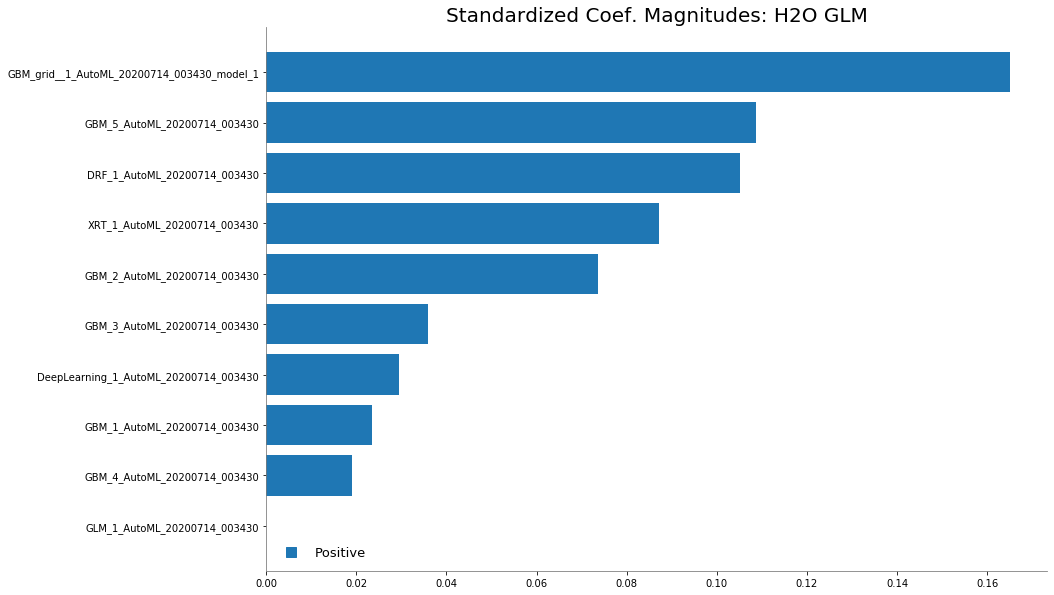

In [267]:
%matplotlib inline
metalearner.std_coef_plot()

# Examine the variable importance of the metalearner (combiner) algorithm in the ensemble.
#This shows us how much each base learner is contributing to the ensemble.

In [268]:
# PREDICTING the is_click for test data

test=h2o.import_file('testdata.csv')
pred = aml.predict(test)
pred.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p0,p1
0,0.970766,0.0292338
0,0.958162,0.0418379
0,0.959704,0.0402956
0,0.969803,0.0301967
1,0.926957,0.0730433
0,0.973209,0.0267914
0,0.944737,0.055263
0,0.97243,0.0275704
0,0.942097,0.0579027
0,0.96787,0.0321301


In [276]:
# SAVING the output

pred_pd = h2o.as_list(pred)
test_pd = h2o.as_list(test)

pd.merge(test_pd['impression_id'],pred_pd['predict'],left_index=True,right_index=True).rename(columns={'predict':'is_click'}).to_csv('submission_file.csv',index=False)

# END